In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px # choropleth maps
from IPython.display import Image
import os
import sys
import json
# plotly maps
# import plotly.figure_factory as ff
# from urllib.request import urlopen

# sys.path.append(os.path.abspath("C:/Users/Alex/Documents/My Data Files/COVID Research/analysis/mention_2_hashtag.py"))

# from analysis.functions.mention_2_hashtag import * 
# from analysis.functions.datamanip import *

# n grams
from sklearn.feature_extraction.text import CountVectorizer

raw = pd.read_csv('flair.joined.tweets.csv')

# changing date to more readable format
raw['created_at'] = pd.to_datetime(raw['created_at'])

# getting seperated date and time columns
raw['date'] = raw['created_at'].dt.date
raw['week'] = raw['created_at'].dt.week
raw['time'] = raw['created_at'].dt.time
raw['hour'] = raw['created_at'].dt.hour

min_wk = raw['week'].min()
max_wk = raw['week'].max()

min_date = raw['date'].min()
max_date = raw['date'].max()

# changing na to None
raw = raw.fillna('None')

raw = raw[raw['sentiment'] != 'None']

raw['is_negative'] = [1 if 'NEGATIVE' in str(sent) else 0 for sent in raw['sentiment']]
raw['is_positive'] = [1 if 'POSITIVE' in str(sent) else 0 for sent in raw['sentiment']]


def convert_fips(unknown_fips_list, fin):
    
    def convert(fipsline):
        name, postal, fips= fipsline.strip().split('\t')

        return {fips: name}

    fips_dict = {f: n 
                for dic in [convert(line)for line in open(fin, 'r')]
                for f, n in dic.items()}

    return [fips_dict[f'{unknown:02d}'] for unknown in unknown_fips_list]

raw = raw[raw['statefips'] != 'None']

raw['state_name'] = convert_fips([int(float(fips)) for fips in raw['statefips']],
                     '../analysis/functions/state.fips.txt')

us_state_abbrev = json.load(open('state_abbreviations.json'))

raw['state_abv'] = [us_state_abbrev[s] for s in raw['state_name']]

raw['fips'] = [f'{int(float(state)):02d}{int(float(county)):03d}' for i, state, county in raw[['statefips', 'countyfips']].itertuples()]
raw['count'] = 1
# raw.head()

all_splits = pd.to_datetime(['2020-03-05', '2020-03-28', '2020-04-29'])
raw['stage'] = ['s:1' if date < all_splits[0] else 's:2' if date < all_splits[1] else 's:3' if date < all_splits[2] else 's:4' for date in raw['date']]



#########################
# thresholds
thresholds = [0.8, 0.9, 0.95]
for thresh in thresholds:
    raw[f't:{thresh}'] = [1 if float(conf) > thresh else 0 for conf in raw['sent_confidence']]

col = 't:0.8'
raw['category'] = ['NEUT' if t == 0 else 'POS' if p == 1 else 'NEG' for i, n, p, t in raw[['is_negative', 'is_positive', col]].itertuples()]
raw['is_neutral'] = [1 if cat == 'NEUT' else 0 for cat in raw['category']]
raw['is_positive'] = [1 if cat == 'POS' else 0 for cat in raw['category']]
raw['is_negative'] = [1 if cat == 'NEG' else 0 for cat in raw['category']]

raw['is_neutral2'] = raw['is_neutral']
raw['is_positive2'] = raw['is_positive']
raw['is_negative2'] = raw['is_negative']

raw['is_neutral3'] = raw['is_neutral']
raw['is_positive3'] = raw['is_positive']
raw['is_negative3'] = raw['is_negative']

##################
# cdc

keywords = ['social distancing', 'social distance', 'physical distance', '6 feet', 'stay at home', 'school isolation', 'isolation', 'stay home', 'avoid touching', 'mask', 'covering', 'face shield', 'wear a mask', 'surgical mask', 'N95 respirator', 'wearing gloves', 'face shields', 'facial covering', 'skin protection', 'eye protection', 'ppe', 'wash hands', 'hand sanitizer', 'disinfect', 'clean', 'detergent', 'handwashing', 'hand hygiene', 'prevention hygiene', 'sprays', 'concentrates', 'wipes', 'routine cleaning', 'bleach solution', 'test', 'business closure']

topics = []
indexes = {i:0 for i in range(len(raw.index))}

for i, topic in enumerate(keywords):
    topics.append([1 if topic in text else 0 for text in raw['ogtext']])

for i, kw in enumerate(topics):
    for data_ind, value in enumerate(topics[i]):
        indexes[data_ind] += value

raw['in_cdc'] = [indexes[i] if 0 <= indexes[i] <= 1 else 1 for i in indexes]

cdc = raw[raw['in_cdc'] == 1]

cdc_splits = pd.to_datetime(['2020-03-15', '2020-04-29', '2020-05-22'])
cdc['stage'] = ['s:1' if date < cdc_splits[0] else 's:2' if date < cdc_splits[1] else 's:3' if date < cdc_splits[2] else 's:4' for date in cdc['date']]

# print(f'there are a total of {len(cdc.index)} tweets after subsetting for cdc keywords')
# print(raw)
# print(cdc)
print('loaded...')

loaded...
<ipython-input-1-3aafff0cc90a>:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdc['stage'] = ['s:1' if date < cdc_splits[0] else 's:2' if date < cdc_splits[1] else 's:3' if date < cdc_splits[2] else 's:4' for date in cdc['date']]


# Setting Threshold to 0.8

moved into main chunk

In [62]:
# thresholds = [0.8, 0.9, 0.95]
# for thresh in thresholds:
#     raw[f't:{thresh}'] = [1 if float(conf) > thresh else 0 for conf in raw['sent_confidence']]

# # raw['is_neutral'] = 0

# # colslist = ['t:0.8', 't:0.9', 't:0.95']

# # for i, col in enumerate(colslist):

# col = 't:0.8'
# raw['category'] = ['NEUT' if t == 1 else 'POS' if p == 1 else 'NEG' for i, n, p, t in raw[['is_negative', 'is_positive', col]].itertuples()]
# raw['is_neutral'] = [1 if cat == 'NEUT' else 0 for cat in raw['category']]
# raw['is_positive'] = [1 if cat == 'POS' else 0 for cat in raw['category']]
# raw['is_negative'] = [1 if cat == 'NEG' else 0 for cat in raw['category']]

# # raw['category'] = ['NEUT' if t == 0 else 'POS' if p == 1 else 'NEG' for i, n, p, t in raw[['is_negative', 'is_positive', 't:0.8']].itertuples()]
# # raw['is_neutral'] = [1 if cat == 'NEUT' else 0 for cat in raw['category']]
# # raw['is_positive'] = [1 if cat == 'POS' else 0 for cat in raw['category']]
# # raw['is_negative'] = [1 if cat == 'NEG' else 0 for cat in raw['category']]

# raw['is_neutral2'] = raw['is_neutral']
# raw['is_positive2'] = raw['is_positive']
# raw['is_negative2'] = raw['is_negative']

# raw['is_neutral3'] = raw['is_neutral']
# raw['is_positive3'] = raw['is_positive']
# raw['is_negative3'] = raw['is_negative']

# # raw[raw['category'] == 'NEUT'][['is_negative', 'is_positive', 'is_neutral', 't:0.8', 'category']].head(50)

# summary statistics

In [2]:
print(f'min date = {raw["date"].min()}, max date = {raw["date"].max()}')

print(f'in the raw dataset ....')

nneg, avgneg, stdneg = raw.agg({'is_negative3':'sum', 'is_negative':'mean', 'is_negative2':'std'})
npos, avgpos, stdpos = raw.agg({'is_positive3':'sum', 'is_positive':'mean', 'is_positive2':'std'})
nneut, avgneut, stdneut = raw.agg({'is_neutral3':'sum', 'is_neutral':'mean', 'is_neutral2':'std'})
per_day = raw.groupby(['date']).agg({'count':'count'}).mean()[0]
std_day = raw.groupby(['date']).agg({'count':'count'}).std()[0]
per_week = raw.groupby(['week']).agg({'count':'count'}).mean()[0]
std_week = raw.groupby(['week']).agg({'count':'count'}).std()[0]
nLocations = len(raw['state_name'].unique())


print(f'NEGATIVE: nneg words = {nneg}, avg neg = {avgneg}, std neg = {avgneg}')
print(f'POSITVE: npos words = {npos}, avg neg = {avgpos}, std neg = {stdpos}')
print(f'NEUTRAL: nneut words = {nneut}, avg neg = {avgneut}, std neg = {stdneut}')
print(f'avg tweets per day = {per_day}, std = {std_day}')
print(f'avg tweets per week = {per_week}, std = {std_week}')
print(f'number of unique locations = {nLocations}')


print()
print(f'in the cdc subset ....')

nneg, avgneg, stdneg = cdc.agg({'is_negative3':'sum', 'is_negative':'mean', 'is_negative2':'std'})
npos, avgpos, stdpos = cdc.agg({'is_positive3':'sum', 'is_positive':'mean', 'is_positive2':'std'})
nneut, avgneut, stdneut = cdc.agg({'is_neutral3':'sum', 'is_neutral':'mean', 'is_neutral2':'std'})
per_day = cdc.groupby(['date']).agg({'count':'count'}).mean()[0]
std_day = cdc.groupby(['date']).agg({'count':'count'}).std()[0]
per_week = cdc.groupby(['week']).agg({'count':'count'}).mean()[0]
std_week = cdc.groupby(['week']).agg({'count':'count'}).std()[0]
nLocations = len(cdc['state_name'].unique())

print(f'NEGATIVE: nneg words = {nneg}, avg neg = {avgneg}, std neg = {avgneg}')
print(f'POSITVE: npos words = {npos}, avg neg = {avgpos}, std neg = {stdpos}')
print(f'NEUTRAL: nneut words = {nneut}, avg neg = {avgneut}, std neg = {stdneut}')
print(f'avg tweets per day = {per_day}, std = {std_day}')
print(f'avg tweets per week = {per_week}, std = {std_week}')
print(f'number of unique locations = {nLocations}')

min date = 2020-01-22, max date = 2020-06-12
in the raw dataset ....
NEGATIVE: nneg words = 195166.0, avg neg = 0.566983713809272, std neg = 0.566983713809272
POSITVE: npos words = 103698.0, avg neg = 0.30125676170333915, std neg = 0.458804682591042
NEUTRAL: nneut words = 45354.0, avg neg = 0.1317595244873888, std neg = 0.3382296328527284
avg tweets per day = 2424.0704225352115, std = 1488.957885118977
avg tweets per week = 16391.333333333332, std = 6935.529138669474
number of unique locations = 54

in the cdc subset ....
NEGATIVE: nneg words = 32408.0, avg neg = 0.6083496020423487, std neg = 0.6083496020423487
POSITVE: npos words = 13411.0, avg neg = 0.25174575762126444, std neg = 0.43402000784303973
NEUTRAL: nneut words = 7453.0, avg neg = 0.13990464033638683, std neg = 0.3468913241942511
avg tweets per day = 375.15492957746477, std = 294.5514511708853
avg tweets per week = 2536.7619047619046, std = 1529.666136931909
number of unique locations = 54


# thresholds

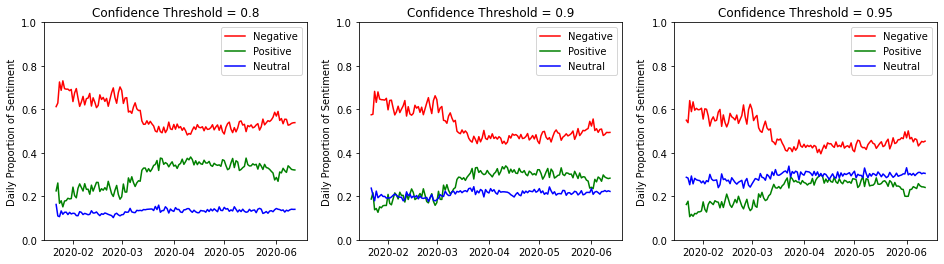

In [164]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 4)) #sharey = True

colslist = ['t:0.8', 't:0.9', 't:0.95']

for i, col in enumerate(colslist):

    ndf = raw

    ndf['category'] = ['NEUT' if t == 0 else 'POS' if p == 1 else 'NEG' for i, n, p, t in ndf[['is_negative', 'is_positive', col]].itertuples()]
    ndf['NEUT'] = [1 if cat == 'NEUT' else 0 for cat in ndf['category']]
    ndf['POS'] = [1 if cat == 'POS' else 0 for cat in ndf['category']]
    ndf['NEG'] = [1 if cat == 'NEG' else 0 for cat in ndf['category']]

    ndf = ndf.groupby(['date']).agg({'NEG':'mean', 'POS':'mean', 'NEUT':'mean'}).reset_index() 

    ax[i].plot(ndf['date'], ndf.NEG, color= 'r', label='Negative')
    ax[i].plot(ndf['date'], ndf.POS, color = 'g', label='Positive')
    ax[i].plot(ndf['date'], ndf.NEUT, color = 'b', label='Neutral')
    # ax[i].plot((min_date,max_date),(0.5,0.5), color='black', alpha=0.3)
    ax[i].set_ylabel('Daily Proportion of Sentiment')
    ax[i].set_title(f'Confidence Threshold = {col.split(":")[1]}')
    ax[i].set_ylim(0,1)
    ax[i].legend()
plt.show()


# General stats

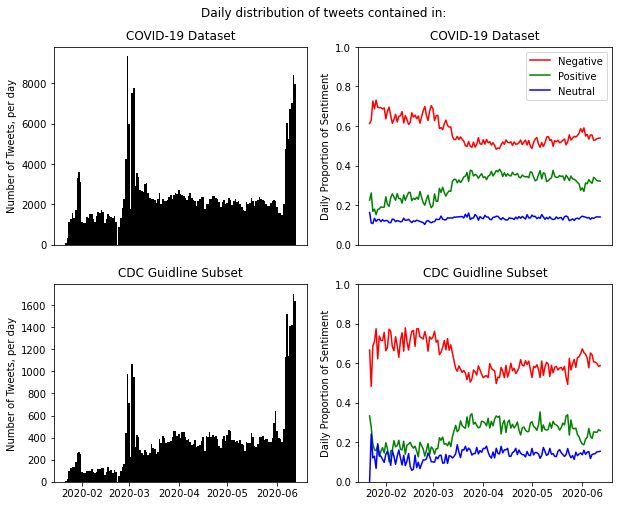

In [161]:
# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4)) #sharey = True
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8)) #sharey = True

# ndf = raw.groupby(['date']).agg({'is_negative':'mean', 'count':'count'}).reset_index()
# ndf['nnegative'] = ndf['count'] * ndf['is_negative']
# ndf['npositive'] = ndf['count'] - ndf['nnegative']
# ndf['is_positive'] = 1 - ndf['is_negative']

ndf = raw.groupby(['date']).agg({'count':'count', 'is_negative':'mean', 'is_negative2':'sum', 'is_positive':'mean', 'is_positive2':'sum', 'is_neutral':'mean', 'is_neutral2':'sum'}).reset_index()
ndf['nnegative'] = ndf['is_negative2']
ndf['npositive'] = ndf['is_positive2']
ndf['nneutral'] = ndf['is_neutral2']
# sum = ndf['count'].sum()
# avg_day = ndf['count'].mean()
# npos = int(ndf['npositive'].sum())
# nneg = int(ndf['nnegative'].sum())

# # urban rural split by weeks
# df = raw.groupby(['week', 'is_urban']).agg({'is_negative':'mean', 'count':'count', 'is_positive':'mean'}).reset_index()
# urban = df[df['is_urban'] == 1]
# rural = df[df['is_urban'] == 0]
# avg_wk = df['count'].mean()

# ax[0].bar(ndf['date'], ndf.npositive, color= 'black', label='negative')
# ax[0].bar(ndf['date'], ndf.nnegative, bottom = ndf.npositive, color = 'black', label='positive',width=1.0)
ax[0,0].bar(ndf['date'], ndf['count'], color= 'black', label='all tweets', width=1.0)
ax[0,0].set_ylabel('Number of Tweets, per day')
# ax[0,0].set_xlabel('per day')
ax[0,0].set_title(f'COVID-19 Dataset', y=1.01)

ax[0,1].plot(ndf['date'], ndf.is_negative, color= 'r', label='Negative')
ax[0,1].plot(ndf['date'], ndf.is_positive, color = 'g', label='Positive')
ax[0,1].plot(ndf['date'], ndf.is_neutral, color = 'b', label='Neutral')
# ax[0,1].plot((min_date,max_date),(0.5,0.5), color='black', alpha=0.3)
ax[0,1].set_ylabel('Daily Proportion of Sentiment')
# ax[0,1].set_xlabel('per day')
ax[0,1].set_title(f'COVID-19 Dataset', y=1.01)
ax[0,1].set_ylim(0,1)
ax[0,1].legend()
ax[0, 0].get_xaxis().set_visible(False)
ax[0, 1].get_xaxis().set_visible(False)

###########################################################

# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4)) #sharey = True

ndf = cdc.groupby(['date']).agg({'count':'count', 'is_negative':'mean', 'is_negative2':'sum', 'is_positive':'mean', 'is_positive2':'sum', 'is_neutral':'mean', 'is_neutral2':'sum'}).reset_index()
ndf['nnegative'] = ndf['is_negative2']
ndf['npositive'] = ndf['is_positive2']
ndf['nneutral'] = ndf['is_neutral2']
# sum = ndf['count'].sum()
# avg_day = ndf['count'].mean()
# npos = int(ndf['npositive'].sum())
# nneg = int(ndf['nnegative'].sum())

# # urban rural split by weeks
# df = cdc.groupby(['week', 'is_urban']).agg({'is_negative':'mean', 'count':'count', 'is_positive':'mean'}).reset_index()
# urban = df[df['is_urban'] == 1]
# rural = df[df['is_urban'] == 0]
# avg_wk = df['count'].mean()

# ax[0].bar(ndf['date'], ndf.npositive, color= 'black', label='negative')
# ax[0].bar(ndf['date'], ndf.nnegative, bottom = ndf.npositive, color = 'black', label='positive',width=1.0)
ax[1,0].bar(ndf['date'], ndf['count'], color= 'black', label='all tweets', width=1.0)
ax[1,0].set_ylabel('Number of Tweets, per day')
# ax[1,0].set_xlabel('per day')
ax[1,0].set_title(f'CDC Guidline Subset', y=1.01)
# ax[1,0].set_ylim(0,8000)

ax[1,1].plot(ndf['date'], ndf.is_negative, color= 'r', label='negative')
ax[1,1].plot(ndf['date'], ndf.is_positive, color = 'g', label='positive')
ax[1,1].plot(ndf['date'], ndf.is_neutral, color = 'b', label='neutral')
# ax[1,1].plot((min_date,max_date),(0.5,0.5), color='black', alpha=0.3)
ax[1,1].set_ylabel('Daily Proportion of Sentiment')
# ax[1,1].set_xlabel('per day')
ax[1,1].set_title(f'CDC Guidline Subset', y=1.01)
ax[1,1].set_ylim(0,1)

# fig.suptitle(f'cdc subsetted data: n={sum}, tweets/day={int(avg_day)}, tweets/week={int(avg_wk)}', y=1.03)
fig.suptitle(f'Daily distribution of tweets contained in:', y=0.95)
plt.show()

# redo general stats

old code on above graph

In [89]:
# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4)) #sharey = True
# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4)) #sharey = True

# ndf = raw.groupby(['date']).agg({'is_negative':'mean', 'count':'count'}).reset_index()
# ndf['nnegative'] = ndf['count'] * ndf['is_negative']
# ndf['npositive'] = ndf['count'] - ndf['nnegative']
# ndf['is_positive'] = 1 - ndf['is_negative']
# sum = ndf['count'].sum()
# avg_day = ndf['count'].mean()
# npos = int(ndf['npositive'].sum())
# nneg = int(ndf['nnegative'].sum())

# # urban rural split by weeks
# df = raw.groupby(['week', 'is_urban']).agg({'is_negative':'mean', 'count':'count', 'is_positive':'mean'}).reset_index()
# urban = df[df['is_urban'] == 1]
# rural = df[df['is_urban'] == 0]
# avg_wk = df['count'].mean()


# ax[0].plot(ndf['date'], ndf['nnegative'], label='all tweets', color= 'r')
# ax[0].plot(ndf['date'], ndf['npositive'], label='all tweets', color = 'b')
# ax[0].set_ylabel('number of tweets')
# ax[0].set_xlabel('per day')
# ax[0].set_title(f'count of tweets')

# ax[1].plot(ndf['date'], ndf.is_negative, color= 'r', label='negative')
# ax[1].plot(ndf['date'], ndf.is_positive, color = 'b', label='positive')
# ax[1].plot((min_date,max_date),(0.5,0.5), color='black', alpha=0.3)
# ax[1].set_ylabel('proportion of sentiment')
# ax[1].set_xlabel('per day')
# ax[1].set_title(f'nPositive={npos}, nNegative={nneg}')
# ax[1].set_ylim(0,1)
# ax[1].legend()

# ndf = cdc.groupby(['date']).agg({'is_negative':'mean', 'count':'count'}).reset_index()
# ndf['nnegative'] = ndf['count'] * ndf['is_negative']
# ndf['npositive'] = ndf['count'] - ndf['nnegative']
# ndf['is_positive'] = 1 - ndf['is_negative']
# sum = ndf['count'].sum()
# avg_day = ndf['count'].mean()
# npos = int(ndf['npositive'].sum())
# nneg = int(ndf['nnegative'].sum())

# # urban rural split by weeks
# df = cdc.groupby(['week', 'is_urban']).agg({'is_negative':'mean', 'count':'count', 'is_positive':'mean'}).reset_index()
# urban = df[df['is_urban'] == 1]
# rural = df[df['is_urban'] == 0]
# avg_wk = df['count'].mean()

# ax[0].plot(ndf['date'], ndf['nnegative'], label='all tweets', color= 'black')
# ax[0].plot(ndf['date'], ndf['npositive'], label='all tweets', color = 'g')
# ax[0].set_ylabel('number of tweets')
# ax[0].set_xlabel('per day')
# ax[0].set_title(f'count of tweets')
# # ax[1,0].set_ylim(0,8000)

# ax[1].plot(ndf['date'], ndf.is_negative, color= 'black', label='negative')
# ax[1].plot(ndf['date'], ndf.is_positive, color = 'g', label='positive')
# ax[1].plot((min_date,max_date),(0.5,0.5), color='black', alpha=0.3)
# ax[1].set_ylabel('proportion of sentiment')
# ax[1].set_xlabel('per day')
# ax[1].set_title(f'nPositive={npos}, nNegative={nneg}')
# ax[1].set_ylim(0,1)

# fig.suptitle(f'red & blue is covid-19 dataset, black and green is cdc subset', y=1.03)
# plt.show()

# stage splitting

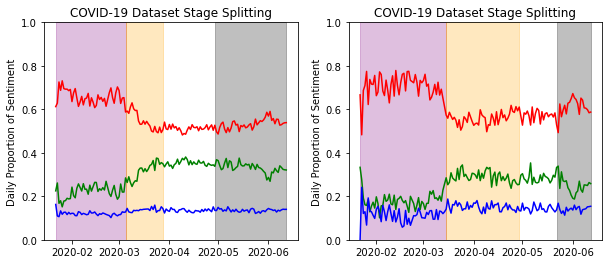

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4)) #sharey = True

ndf = raw.groupby(['date']).agg({'count':'count', 'is_negative':'mean', 'is_negative2':'sum', 'is_positive':'mean', 'is_positive2':'sum', 'is_neutral':'mean', 'is_neutral2':'sum'}).reset_index()
ndf['nnegative'] = ndf['is_negative2']
ndf['npositive'] = ndf['is_positive2']
ndf['nneutral'] = ndf['is_neutral2']
# sum = ndf['count'].sum()
avg_day = ndf['count'].mean()
npos = int(ndf['npositive'].sum())
nneg = int(ndf['nnegative'].sum())

colors = ['purple', 'orange', 'black']
# print(min_date)

ax[0].plot(ndf['date'], ndf.is_negative, color= 'r', label='Negative')
ax[0].plot(ndf['date'], ndf.is_positive, color = 'g', label='Positive')
ax[0].plot(ndf['date'], ndf.is_neutral, color = 'b', label='Neutral')
# ax.plot((min_date,max_date),(0.5,0.5), color='black', alpha=0.3)
for i, split in enumerate(all_splits):
    if i == 0:
        ax[0].axvspan(min_date, split, 0, 1, alpha=0.25, color=colors[0])
        last = split
    if i != len(all_splits)-1:
        ax[0].axvspan(last, split, 0, 1, alpha=0.25, color=colors[1])
        last = split
    if i == len(all_splits)-1:
        ax[0].axvspan(split, max_date, 0, 1, alpha=0.25, color=colors[2])
ax[0].set_ylabel('Daily Proportion of Sentiment')
ax[0].set_title(f'COVID-19 Dataset Stage Splitting')
ax[0].set_ylim(0,1)
# ax.legend()
# plt.show()



ndf = cdc.groupby(['date']).agg({'count':'count', 'is_negative':'mean', 'is_negative2':'sum', 'is_positive':'mean', 'is_positive2':'sum', 'is_neutral':'mean', 'is_neutral2':'sum'}).reset_index()
ndf['nnegative'] = ndf['is_negative2']
ndf['npositive'] = ndf['is_positive2']
ndf['nneutral'] = ndf['is_neutral2']
# sum = ndf['count'].sum()
avg_day = ndf['count'].mean()
npos = int(ndf['npositive'].sum())
nneg = int(ndf['nnegative'].sum())

colors = ['purple', 'orange', 'black']
# print(min_date)

ax[1].plot(ndf['date'], ndf.is_negative, color= 'r', label='Negative')
ax[1].plot(ndf['date'], ndf.is_positive, color = 'g', label='Positive')
ax[1].plot(ndf['date'], ndf.is_neutral, color = 'b', label='Neutral')
# ax.plot((min_date,max_date),(0.5,0.5), color='black', alpha=0.3)
for i, split in enumerate(cdc_splits):
    if i == 0:
        ax[1].axvspan(min_date, split, 0, 1, alpha=0.25, color=colors[0])
        last = split
    if i != len(cdc_splits)-1:
        ax[1].axvspan(last, split, 0, 1, alpha=0.25, color=colors[1])
        last = split
    if i == len(cdc_splits)-1:
        ax[1].axvspan(split, max_date, 0, 1, alpha=0.25, color=colors[2])
ax[1].set_ylabel('Daily Proportion of Sentiment')
ax[1].set_title(f'COVID-19 Dataset Stage Splitting')
ax[1].set_ylim(0,1)
# ax.legend()
plt.show()

# table of stage aresults

In [12]:
print('covid-19 dataset')
table_c19 = raw.groupby(['stage']).agg({'count':'count', 'is_negative':'mean', 'is_positive':'mean', 'is_neutral':'mean'}).reset_index()
table_c19.columns = ['stage', 'n', 'mean Neg', 'mean Pos', 'mean Neut']

df2 = raw.groupby(['count']).agg({'is_negative':'mean', 'is_positive':'mean', 'is_neutral':'mean'}).reset_index()
df2.columns = ['n', 'mean Neg', 'mean Pos', 'mean Neut']
df2['n'] = len(raw.index)
print(df2)
print(table_c19)
print()

print('cdc subset')
table_cdc = cdc.groupby(['stage']).agg({'count':'count', 'is_negative':'mean', 'is_positive':'mean', 'is_neutral':'mean'}).reset_index()
table_cdc.columns = ['stage', 'n', 'mean Neg', 'mean Pos', 'mean Neut']

df2 = cdc.groupby(['count']).agg({'is_negative':'mean', 'is_positive':'mean', 'is_neutral':'mean'}).reset_index()
df2.columns = ['n', 'mean Neg', 'mean Pos', 'mean Neut']
df2['n'] = len(cdc.index)
print(df2)
print(table_cdc)

covid-19 dataset
        n  mean Neg  mean Pos  mean Neut
0  344218  0.566984  0.301257    0.13176
  stage       n  mean Neg  mean Pos  mean Neut
0   s:1   89757  0.666321  0.214000   0.119679
1   s:2   58010  0.552663  0.310205   0.137132
2   s:3   72849  0.512704  0.352139   0.135156
3   s:4  123602  0.533559  0.330432   0.136009

cdc subset
       n  mean Neg  mean Pos  mean Neut
0  53272   0.60835  0.251746   0.139905
  stage      n  mean Neg  mean Pos  mean Neut
0   s:1  11475  0.706492  0.178039   0.115468
1   s:2  16859  0.558693  0.289460   0.151848
2   s:3   8610  0.574332  0.282462   0.143206
3   s:4  16328  0.608586  0.248408   0.143006


# topic analysis

run finder for categories

In [9]:
social = ['social distancing', 'social distance', 'physical distance', '6 feet', 'stay at home', 'school isolation', 'isolation', 'stay home', 'avoid touching']
gear = ['mask', 'covering', 'face shield', 'wear a mask', 'surgical mask', 'N95 respirator', 'wearing gloves', 'face shields', 'facial covering', 'skin protection', 'eye protection', 'ppe']
clean = ['wash hands', 'hand sanitizer', 'disinfect', 'clean', 'detergent', 'handwashing', 'hand hygiene', 'prevention hygiene', 'sprays', 'concentrates', 'wipes', 'routine cleaning', 'bleach solution']
other = ['test', 'business closure']

categories = [social, gear, clean, other]
cat_names = ['Physical or social distancing', 'Personal  protective  equipment', 'Disinfection', 'Others']

for i in range(4):
    raw[cat_names[i]] = 0

for i, text in enumerate(raw.ogtext): # it would be faster to rewrite this to itertuples
    for k, cat in enumerate(categories):
        ncat = 0
        for token in cat:
            if token in str(text):
                ncat += 1
        if ncat > 0:
            raw.loc[i,f'{cat_names[k]}'] = 1

tables of categories

In [23]:

for cat in cat_names: 
    df1 = raw[raw[cat]==1].groupby(['stage']).agg({'count':'count', 'is_negative':'mean', 'is_negative2':'std', 'is_positive':'mean', 'is_positive2':'std', 'is_neutral':'mean', 'is_neutral2':'std'}).reset_index()
    df1.columns = ['stage', 'n', 'mean Neg', 'std Neg', 'mean Pos', 'std Pos', 'mean Neut', 'std Neut']

    df2 = raw[raw[cat]==1].groupby(['count']).agg({'is_negative':'mean', 'is_negative2':'std', 'is_positive':'mean', 'is_positive2':'std', 'is_neutral':'mean', 'is_neutral2':'std'}).reset_index()
    df2.columns = ['n', 'mean Neg', 'std Neg', 'mean Pos', 'std Pos', 'mean Neut', 'std Neut']
    df2['n'] = len(raw[raw[cat]==1].index)

    print(f'category: {cat}')
    print(df2)
    print(df1)
    print()

category: Physical or social distancing
       n  mean Neg   std Neg  mean Pos   std Pos  mean Neut  std Neut
0  19466  0.548833  0.497623  0.318505  0.465909   0.132662  0.339218
  stage     n  mean Neg   std Neg  mean Pos   std Pos  mean Neut  std Neut
0   s:1  1951  0.669913  0.470365  0.218350  0.413232   0.111738  0.315124
1   s:2  2324  0.545181  0.498062  0.314974  0.464606   0.139845  0.346901
2   s:3  5019  0.514246  0.499847  0.355649  0.478757   0.130106  0.336453
3   s:4  9679  0.543238  0.498153  0.320281  0.466609   0.136481  0.343316

category: Personal  protective  equipment
       n  mean Neg   std Neg  mean Pos   std Pos  mean Neut  std Neut
0  19640  0.568064  0.495359  0.299419  0.458016   0.132517  0.339061
  stage     n  mean Neg   std Neg  mean Pos   std Pos  mean Neut  std Neut
0   s:1  4087  0.671152  0.469852  0.213604  0.409901   0.115243  0.319355
1   s:2  2390  0.553556  0.497227  0.309623  0.462435   0.136820  0.343729
2   s:3  3129  0.522531  0.499572  0.

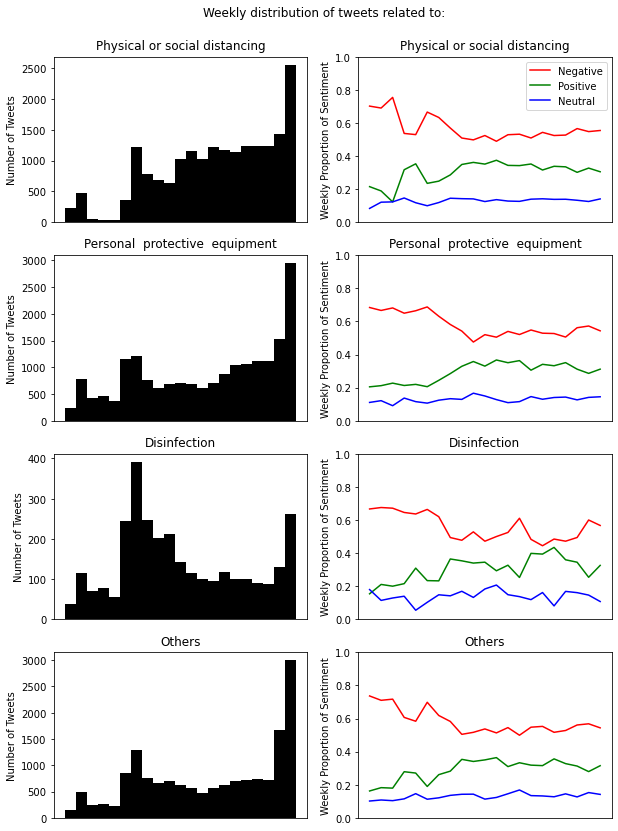

In [141]:
fig, ax = plt.subplots(nrows=len(cat_names), ncols=2, figsize=(10, 14)) #sharey = True
for i, cat in enumerate(cat_names): 
    # fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4)) #sharey = True

    ndf = raw[raw[cat]==1].groupby(['week']).agg({'count':'count', 'is_negative':'mean', 'is_negative2':'sum', 'is_positive':'mean', 'is_positive2':'sum', 'is_neutral':'mean', 'is_neutral2':'sum'}).reset_index()
    ndf['nnegative'] = ndf['is_negative2']
    ndf['npositive'] = ndf['is_positive2']
    ndf['nneutral'] = ndf['is_neutral2']
    # sum = ndf['count'].sum()
    # avg_day = ndf['count'].mean()
    # npos = int(ndf['npositive'].sum())
    # nneg = int(ndf['nnegative'].sum())

    # urban rural split by weeks
    # df = raw.groupby(['week', 'is_urban']).agg({'is_negative':'mean', 'count':'count', 'is_positive':'mean'}).reset_index()
    # urban = df[df['is_urban'] == 1]
    # rural = df[df['is_urban'] == 0]
    # avg_wk = df['count'].mean()

    # ax[0].bar(ndf['date'], ndf.npositive, color= 'black', label='negative')
    # ax[0].bar(ndf['date'], ndf.nnegative, bottom = ndf.npositive, color = 'black', label='positive',width=1.0)
    ax[i, 0].bar(ndf['week'], ndf['count'], color= 'black', label='all tweets', width=1.0)
    ax[i, 0].set_ylabel('Number of Tweets')
    ax[i, 1].set_ylabel('Weekly Proportion of Sentiment')
    if i == 3:
        ax[i, 0].get_xaxis().set_visible(False)
        # ax[i, 0].set_xticklabels(['2020-02', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06'])
        # ax[i, 0].set_xlabel('per week')
    else:
        ax[i, 0].get_xaxis().set_visible(False)
    ax[i, 0].set_title(f'{cat}', y=1.01)
    ax[i, 1].set_title(f'{cat}', y=1.01)

    ax[i, 1].plot(ndf['week'], ndf.is_negative, color= 'r', label='Negative')
    ax[i, 1].plot(ndf['week'], ndf.is_positive, color = 'g', label='Positive')
    ax[i, 1].plot(ndf['week'], ndf.is_neutral, color = 'b', label='Neutral')
    # ax[i, 1].plot((min_wk-1,max_wk+1),(0.5,0.5), color='black', alpha=0.3)
    # ax[1].plot((min_date,max_date),(0.5,0.5), color='black', alpha=0.3)
    # ax[i, 1].set_ylabel('proportion of sentiment')
    if i == 3:
        # ax[i, 1].set_xticklabels(['2020-02', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06'])
        ax[i, 1].get_xaxis().set_visible(False)
        # ax[i,1].set_xticks(labs)
        # ax[i, 1].set_xlabel('per week')
    else:      
        ax[i, 1].get_xaxis().set_visible(False)
    # ax[i, 1].set_title(f'nPositive={npos}, nNegative={nneg}')
    ax[i, 1].set_ylim(0,1)
   
    ax[0, 1].legend()

    fig.suptitle('Weekly distribution of tweets related to:', y=0.93)

# keyword table

In [15]:
# for topic in keywords:
#     raw['keep'] = [1 if topic in str(text) else 0 for text in raw.ogtext]
#     df1 = raw[raw['keep']==1].groupby(['stage']).agg({'count':'count', 'is_negative':'mean', 'is_positive':'std'}).reset_index()
#     df1.columns = ['stage', 'n', 'mean Neg', 'std Neg']

#     df2 = raw[raw['keep']==1].groupby(['count']).agg({'is_negative':'mean', 'is_positive':'std'}).reset_index()
#     df2.columns = ['n', 'mean Neg', 'std Neg']
#     df2['n'] = len(raw[raw['keep']==1].index)
#     print(f'keyword: {topic}')
#     print(df2)
#     print(df1)
#     print()


# covid-19 state table

In [18]:
for state, df in raw.groupby(['state_abv']):

    df1 = df.groupby(['stage']).agg({'count':'count', 'is_negative':'mean', 'is_negative2':'std', 'is_positive':'mean', 'is_positive2':'std', 'is_neutral':'mean', 'is_neutral2':'std'}).reset_index()
    df1.columns = ['stage', 'n', 'mean Neg', 'std Neg', 'mean Pos', 'std Pos', 'mean Neut', 'std Neut']

    df2 = df.groupby(['count']).agg({'is_negative':'mean', 'is_negative2':'std', 'is_positive':'mean', 'is_positive2':'std', 'is_neutral':'mean', 'is_neutral2':'std'}).reset_index()
    df2.columns = ['n', 'mean Neg', 'std Neg', 'mean Pos', 'std Pos', 'mean Neut', 'std Neut']
    df2['n'] = len(df.index)
    print(f'state: {state}')
    print(df2)
    print(df1)
    print()
    

state: AK
     n  mean Neg   std Neg  mean Pos   std Pos  mean Neut  std Neut
0  465  0.591398  0.492105  0.288172  0.453399    0.12043  0.325814
  stage    n  mean Neg   std Neg  mean Pos   std Pos  mean Neut  std Neut
0   s:1  133  0.669173  0.472290  0.233083  0.424393   0.097744  0.298091
1   s:2   95  0.547368  0.500392  0.315789  0.467295   0.136842  0.345504
2   s:3  105  0.580952  0.495770  0.314286  0.466457   0.104762  0.307715
3   s:4  132  0.553030  0.499074  0.303030  0.461319   0.143939  0.352366

state: AL
      n  mean Neg   std Neg  mean Pos   std Pos  mean Neut  std Neut
0  3299  0.555623  0.496972  0.308578  0.461977   0.135799  0.342627
  stage     n  mean Neg   std Neg  mean Pos   std Pos  mean Neut  std Neut
0   s:1   881  0.654938  0.475659  0.227015  0.419140   0.118048  0.322848
1   s:2   570  0.533333  0.499326  0.331579  0.471194   0.135088  0.342117
2   s:3   695  0.520863  0.499924  0.335252  0.472418   0.143885  0.351226
3   s:4  1153  0.511709  0.500080  

# cdc subset state table

In [19]:
for state, df in cdc.groupby(['state_abv']):
    df1 = df.groupby(['stage']).agg({'count':'count', 'is_negative':'mean', 'is_negative2':'std', 'is_positive':'mean', 'is_positive2':'std', 'is_neutral':'mean', 'is_neutral2':'std'}).reset_index()
    df1.columns = ['stage', 'n', 'mean Neg', 'std Neg', 'mean Pos', 'std Pos', 'mean Neut', 'std Neut']

    df2 = df.groupby(['count']).agg({'is_negative':'mean', 'is_negative2':'std', 'is_positive':'mean', 'is_positive2':'std', 'is_neutral':'mean', 'is_neutral2':'std'}).reset_index()
    df2.columns = ['n', 'mean Neg', 'std Neg', 'mean Pos', 'std Pos', 'mean Neut', 'std Neut']
    df2['n'] = len(df.index)
    print(f'state: {state}')
    print(df2)
    print(df1)
    print()

state: AK
    n  mean Neg   std Neg  mean Pos   std Pos  mean Neut  std Neut
0  73  0.561644  0.499619  0.328767  0.473016   0.109589  0.314539
  stage   n  mean Neg   std Neg  mean Pos   std Pos  mean Neut  std Neut
0   s:1  13  0.692308  0.480384  0.307692  0.480384   0.000000  0.000000
1   s:2  27  0.481481  0.509175  0.407407  0.500712   0.111111  0.320256
2   s:3  13  0.615385  0.506370  0.076923  0.277350   0.307692  0.480384
3   s:4  20  0.550000  0.510418  0.400000  0.502625   0.050000  0.223607

state: AL
     n  mean Neg   std Neg  mean Pos   std Pos  mean Neut  std Neut
0  475  0.562105  0.496651  0.244211  0.430071   0.193684  0.395601
  stage    n  mean Neg   std Neg  mean Pos   std Pos  mean Neut  std Neut
0   s:1   87  0.655172  0.478067  0.137931  0.346827   0.206897  0.407429
1   s:2  161  0.527950  0.500776  0.291925  0.456067   0.180124  0.385490
2   s:3   89  0.460674  0.501275  0.292135  0.457320   0.247191  0.433823
3   s:4  138  0.608696  0.489820  0.224638  0.41

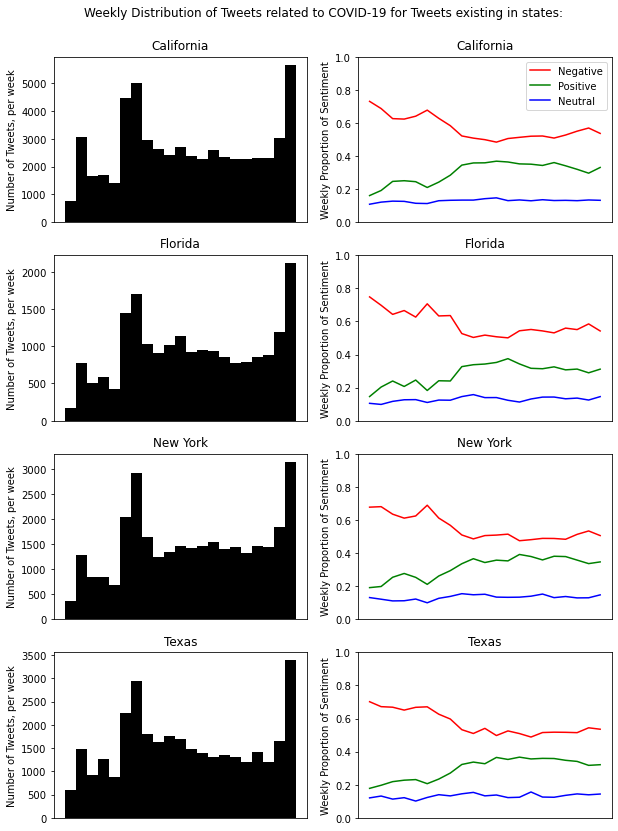

In [158]:
chosen_states = ['California', 'Texas', 'New York', 'Florida']

states = raw[raw['state_name'].isin(chosen_states)]

fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(10, 14)) #sharey = True

for i, (state, df) in enumerate(states.groupby('state_name')):

    ndf = df.groupby(['week']).agg({'count':'count', 'is_negative':'mean', 'is_negative2':'sum', 'is_positive':'mean', 'is_positive2':'sum', 'is_neutral':'mean', 'is_neutral2':'sum'}).reset_index()
    ndf['nnegative'] = ndf['is_negative2']
    ndf['npositive'] = ndf['is_positive2']
    ndf['nneutral'] = ndf['is_neutral2']
    # sum = ndf['count'].sum()
    # avg_day = ndf['count'].mean()
    # npos = int(ndf['npositive'].sum())
    # nneg = int(ndf['nnegative'].sum())


    ax[i,0].bar(ndf['week'], ndf['count'], color= 'black', label='all tweets', width=1.0)
    ax[i,0].set_ylabel('Number of Tweets, per week')
    ax[i,0].set_title(f'{state}', y=1.01)
    ax[i,1].set_title(f'{state}', y=1.01)
    if i == 3:
        # ax[i, 0].set_xlabel('per week')
        ax[i, 0].get_xaxis().set_visible(False)
    else:
        ax[i, 0].get_xaxis().set_visible(False)

    ax[i,1].plot(ndf['week'], ndf.is_negative, color= 'r', label='Negative')
    ax[i,1].plot(ndf['week'], ndf.is_positive, color = 'g', label='Positive')
    ax[i,1].plot(ndf['week'], ndf.is_neutral, color = 'b', label='Neutral')
    # ax[1].plot((min_date,max_date),(0.5,0.5), color='black', alpha=0.3)
    # ax[i,1].plot((min_wk-1,max_wk+1),(0.5,0.5), color='black', alpha=0.3)
    ax[i,1].set_ylabel('Weekly Proportion of Sentiment')
    # ax[i,1].set_title(f'nPositive={npos}, nNegative={nneg}')
    ax[i,1].set_ylim(0,1)
    # ax[i,1].legend()
    if i == 3:
        # ax[i, 1].set_xlabel('per week')
        ax[i, 1].get_xaxis().set_visible(False)
    else:
        ax[i, 1].get_xaxis().set_visible(False)

    ax[0,1].legend()

    fig.suptitle(f'Weekly Distribution of Tweets related to COVID-19 for Tweets existing in states:', y=.93)
plt.show()

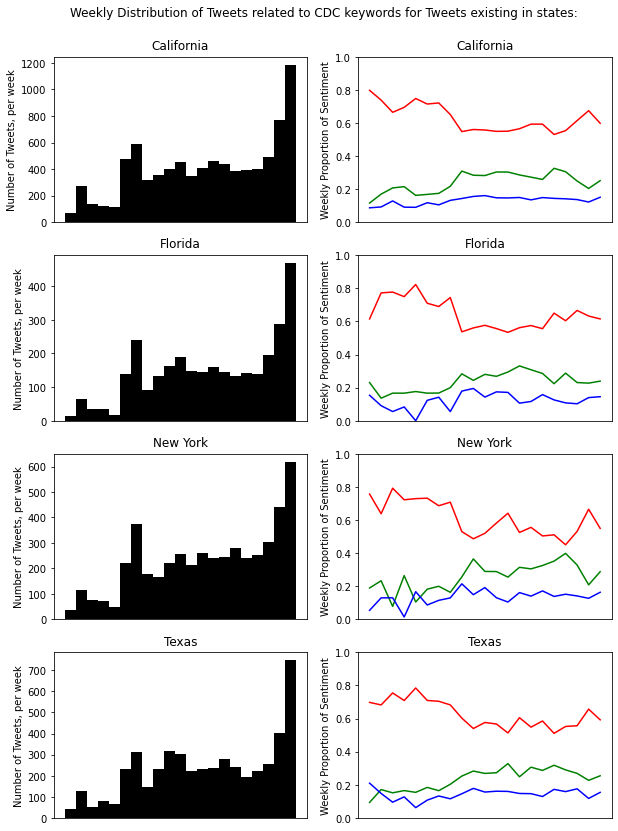

In [155]:
chosen_states = ['California', 'Texas', 'New York', 'Florida']

states = cdc[cdc['state_name'].isin(chosen_states)]

fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(10, 14)) #sharey = True

for i, (state, df) in enumerate(states.groupby('state_name')):

    ndf = df.groupby(['week']).agg({'count':'count', 'is_negative':'mean', 'is_negative2':'sum', 'is_positive':'mean', 'is_positive2':'sum', 'is_neutral':'mean', 'is_neutral2':'sum'}).reset_index()
    ndf['nnegative'] = ndf['is_negative2']
    ndf['npositive'] = ndf['is_positive2']
    ndf['nneutral'] = ndf['is_neutral2']
    # sum = ndf['count'].sum()
    # avg_day = ndf['count'].mean()
    # npos = int(ndf['npositive'].sum())
    # nneg = int(ndf['nnegative'].sum())


    ax[i,0].bar(ndf['week'], ndf['count'], color= 'black', label='all tweets', width=1.0)
    ax[i,0].set_ylabel('Number of Tweets, per week')
    ax[i,0].set_title(f'{state}', y=1.01)
    ax[i,1].set_title(f'{state}', y=1.01)
    if i == 3:
        # ax[i, 0].set_xlabel('per week')
        ax[i, 0].get_xaxis().set_visible(False)
    else:
        ax[i, 0].get_xaxis().set_visible(False)

    ax[i,1].plot(ndf['week'], ndf.is_negative, color= 'r', label='Negative')
    ax[i,1].plot(ndf['week'], ndf.is_positive, color = 'g', label='Positive')
    ax[i,1].plot(ndf['week'], ndf.is_neutral, color = 'b', label='Neutral')
    # ax[1].plot((min_date,max_date),(0.5,0.5), color='black', alpha=0.3)
    # ax[i,1].plot((min_wk-1,max_wk+1),(0.5,0.5), color='black', alpha=0.3)
    ax[i,1].set_ylabel('Weekly Proportion of Sentiment')
    # ax[i,1].set_title(f'nPositive={npos}, nNegative={nneg}')
    ax[i,1].set_ylim(0,1)
    # ax[i,1].legend()
    if i == 3:
        # ax[i, 1].set_xlabel('per week')
        ax[i, 1].get_xaxis().set_visible(False)
    else:
        ax[i, 1].get_xaxis().set_visible(False)

    # ax[0,1].legend()

    fig.suptitle(f'Weekly Distribution of Tweets related to CDC keywords for Tweets existing in states:', y=.93)
plt.show()